<a href="https://colab.research.google.com/github/jazaineam1/Andes_ADDBD/blob/main/Sesion13/Clase_13_Regresio%CC%81n_Logi%CC%81stica_y_metricas_VERSION2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Análisis de Datos y Big data***

## ***Universidad de los Andes***
>## **Dirección de Educación Continua.**
>>## **Formación de habilidades escenciales.**

![Imágen1](https://github.com/jazaineam1/Andes_ADDBD/blob/main/Imagenes/Presentaci%C3%B3n-removebg-preview.png?raw=true)

**Ver la presentación  [acá](https://github.com/jazaineam1/Andes_ADDBD/raw/main/Sesion13/Clase13-Métricas_de_desmpeño_y_selección_de_modelos.pdf)**
# **Regresión logística - Clasificación binaria**



Contamos con una [base de datos](https://www.kaggle.com/datasets/manishkumar7432698/airline-passangers-booking-data?resource=download) con **información de reservaciones de vuelos**. Algunas reservaciones son completadas efectivamente, y otras no.

Para mejorar la experiencia de usuario, la aerolínea desea ofrecer una **promoción especial** a las reservas que usualmente solicitan alimentación durante el vuelo.

Para esto, la idea es que antes de que un usuario indique querer alimentación durante el vuelo, la aerolínea le ofrezca unas entradas gratis. Esto debería mejorar las calificaciones de experiencia de reservación, mitigando los costos (no ofreciéndole comida gratis a todo el mundo).

Para esto **queremos entrentar una máquina que prediga** qué reservaciones van a solicitar alimentación, a partir de otras características insertadas.

## Carga y exploración inicial

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
booking = pd.read_csv("https://raw.githubusercontent.com/jazaineam1/Andes_ADDBD/main/Sesion13/Passanger_booking_data.csv")

In [3]:
booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50002 non-null  int64  
 1   sales_channel          50002 non-null  object 
 2   trip_type              50002 non-null  object 
 3   purchase_lead          50002 non-null  int64  
 4   length_of_stay         50002 non-null  int64  
 5   flight_hour            50002 non-null  int64  
 6   flight_day             50002 non-null  object 
 7   route                  50002 non-null  object 
 8   booking_origin         50002 non-null  object 
 9   wants_extra_baggage    50002 non-null  int64  
 10  wants_preferred_seat   50002 non-null  int64  
 11  wants_in_flight_meals  50002 non-null  int64  
 12  flight_duration        50002 non-null  float64
 13  booking_complete       50002 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
booking.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [5]:
booking.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,Internet,RoundTrip,21,12,6,Tue,AKLHGH,Australia,0,0,0,7.21,1
1,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
2,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
3,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
4,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0


In [6]:
booking['booking_complete'].value_counts()

booking_complete
0    42523
1     7479
Name: count, dtype: int64

In [7]:
booking['sales_channel'].value_counts()

sales_channel
Internet    44383
Mobile       5619
Name: count, dtype: int64

In [8]:
booking['trip_type'].value_counts()

trip_type
RoundTrip     49498
OneWay          387
CircleTrip      117
Name: count, dtype: int64

## Predicción
Vamos a utilizar un modelo lineal y uno logístico para predecir:

* Si una reserva prefiere comidas en el vuelo

A partir de las características de la reserva:

* Si indica silla preferida
* Si desea equipaje extra
* Longitud de la estadía

<Axes: >

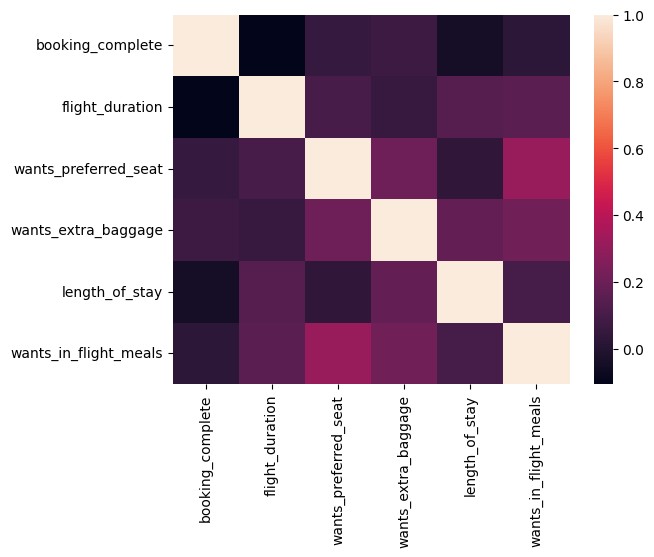

In [9]:
sns.heatmap(booking[["booking_complete","flight_duration",'wants_preferred_seat', 'wants_extra_baggage', 'length_of_stay','wants_in_flight_meals']].corr())

In [10]:
X = booking[['wants_preferred_seat', 'wants_extra_baggage', 'length_of_stay']]
y = booking['wants_in_flight_meals']

In [11]:
# Nuestras predictoras (dos variables dummy y una numérica continua)
X.head()

,wants_preferred_seat,wants_extra_baggage,length_of_stay
0,0,0,12
1,0,1,19
2,0,0,20
3,1,1,22
4,0,0,31


In [12]:
# Nuestra variable a predecir (si en la reservación solicitan alimentos en el vuelo)
y.head()

0    0
1    0
2    0
3    0
4    1
Name: wants_in_flight_meals, dtype: int64

## Separación de datos

Vamos a hablar más en detalle más adelante sobre esto pero:

Siempre que queremos hacer predictiva queremos **no usar la base de datos completa** para calibrar el modelo.

* Queremos usar una parte (70%) para estimar a partir de los datos.
* Queremos usar una parte (30%) para evaluar con datos que el modelo nunca ha visto.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

In [15]:
X_test

,wants_preferred_seat,wants_extra_baggage,length_of_stay
37998,0,0,5
20385,0,1,30
1594,0,1,26
26517,1,1,3
17983,0,1,90
...,...,...,...
42076,0,0,5
35772,0,0,5
44494,1,1,6
44850,1,0,6


## Modelo lineal

In [16]:
modeloLin = LinearRegression()

# Ajustamos el modelo con los datos de entrenamiento (70%)
modeloLin.fit(X_train, y_train)

y_pobabilidades_lin = modeloLin.predict(X_test)

Text(0.5, 0, 'Longitud de la estadía')

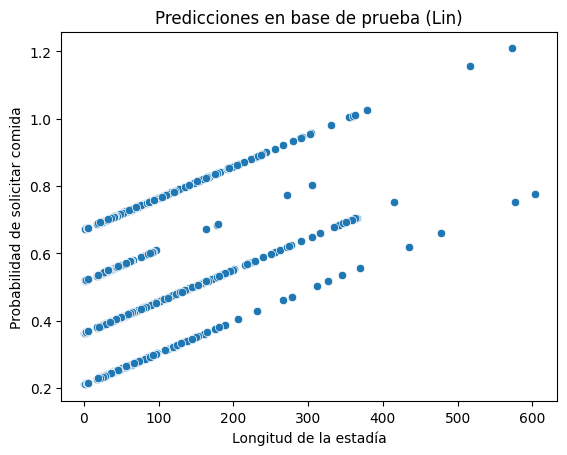

In [17]:
# Las filas que tienen datos completos
X_test_completos = X_test[~X_test.isnull().any(axis=1)]
sns.scatterplot(y=y_pobabilidades_lin, x=X_test_completos['length_of_stay'])
plt.title('Predicciones en base de prueba (Lin)')
plt.ylabel('Probabilidad de solicitar comida')
plt.xlabel('Longitud de la estadía')

**Observamos que:**

* Hay cuatro grupos de predicciones (eso corresponde a que los valores esperados dependen de las otras variables dummy: equipaje y preferencia de silla.

**Ejercicio**: incluir en la dispersión el parámetro:
<pre>
hue=X_test_completos['wants_preferred_seat']
</pre>

Esto permite ver los grupos esperados según otras variables predictoras.

* **Pero más aún:** ¡Algunas probabilidades son mayores a 1!

## Modelo Logístico

In [18]:
modeloLog  = LogisticRegression(random_state=16)

# Ajustamos el modelo con los datos de entrenamiento (70%)
modeloLog.fit(X_train, y_train)

probabilidades = modeloLog.predict_proba(X_test)[:,1]

Text(0.5, 0, 'Longitud de la estadía')

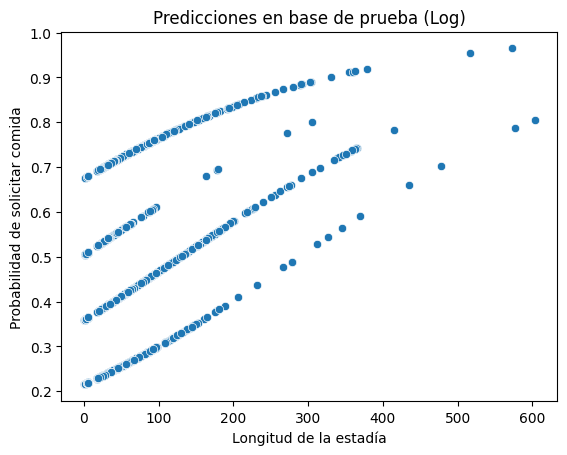

In [19]:
# Las filas que tienen datos completos
X_test_completos = X_test[~X_test.isnull().any(axis=1)]
sns.scatterplot(y=probabilidades, x=X_test_completos['length_of_stay'])
plt.title('Predicciones en base de prueba (Log)')
plt.ylabel('Probabilidad de solicitar comida')
plt.xlabel('Longitud de la estadía')

**Vemos que:**

* Las predicciones de la probabilidad ahora son curvas, no lineales.
* No hay probabilidades por encima de 1 o por debajo de cero.

## Clasificación a partir de las probabilidades

**Para clasificar** predecimos las filas con probabilid superior a 0.5, como cierta categoría, y las demás como la contraria.

### Lineal

In [20]:
pred_lineales = y_pobabilidades_lin>0.5
pred_lineales = pd.DataFrame({'Predicción':pred_lineales})
di = {True: 1, False: 0}
pred_lineales.replace({"Predicción": di}, inplace=True)

In [21]:
pred_lineales.value_counts()

Predicción
0             10404
1              4597
Name: count, dtype: int64

### Logístico

In [22]:
y_pred_log = modeloLog.predict(X_test)

In [23]:
pd.DataFrame(y_pred_log).value_counts()

0    10389
1     4612
Name: count, dtype: int64

## Matrices de confusión

In [24]:
matriz_log = pd.crosstab(y_test, y_pred_log)
matriz_log

col_0,0,1
wants_in_flight_meals,,
0,6970,1563
1,3419,3049


[Text(0.5, 1.0, 'Matriz de confusión modelo Logit')]

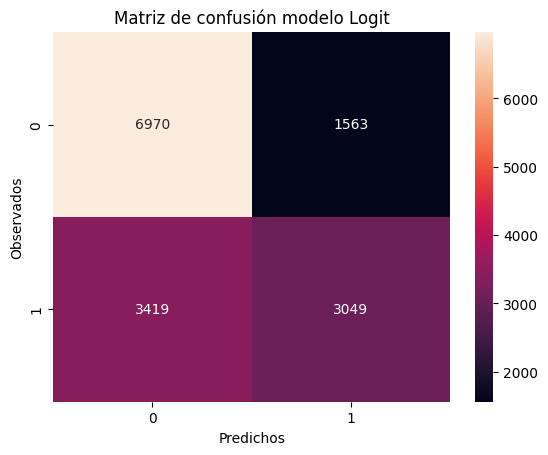

In [25]:
ax = sns.heatmap(matriz_log, annot=True, fmt='.0f')
ax.set(ylabel="Observados", xlabel="Predichos")
ax.set(title="Matriz de confusión modelo Logit")

In [26]:
y_test=y_test.reset_index(drop=True)

In [27]:
matriz_lin = pd.crosstab(y_test, pred_lineales['Predicción'])
matriz_lin

Predicción,0,1
wants_in_flight_meals,,
0,6982,1551
1,3422,3046


[Text(0.5, 1.0, 'Matriz de confusión modelo Lineal')]

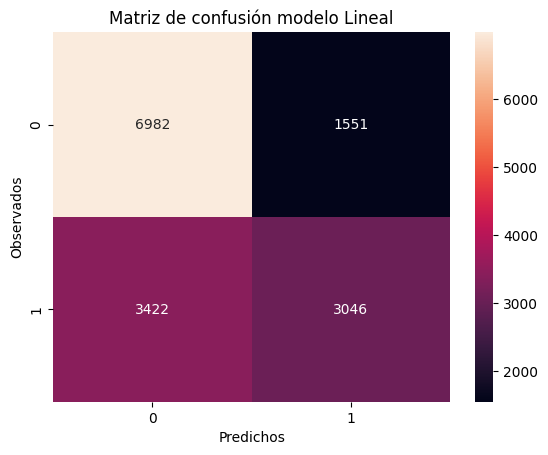

In [28]:
ax = sns.heatmap(matriz_lin, annot=True, fmt='.0f')
ax.set(ylabel="Observados", xlabel="Predichos")
ax.set(title="Matriz de confusión modelo Lineal")

## Métricas
Calculemos el Accuracy, Precision y Recall.
* Accuracy: ¿del total de predicciones cuántas hizo bien?
* Precision: ¿de los que dijo que eran positivos, en cuántos atinó?
* Recall: ¿de todos los que eran positivos, cuántos logró atrapar?

In [29]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report

In [30]:
accuracy=accuracy_score(y_test, y_pred_log)
accuracy

0.6678888074128392

In [31]:
precision=precision_score(y_test, y_pred_log)
precision

0.6611014744145707

In [32]:
recall=recall_score(y_test, y_pred_log)
recall

0.4713976499690785

In [33]:
f1_score=f1_score(y_test, y_pred_log)
f1_score

0.550361010830325

In [34]:
confusion_matrix(y_test, y_pred_log)

array([[6970, 1563],
       [3419, 3049]], dtype=int64)

In [35]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      8533
           1       0.66      0.47      0.55      6468

    accuracy                           0.67     15001
   macro avg       0.67      0.64      0.64     15001
weighted avg       0.67      0.67      0.66     15001

